In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 2 - Image Classification (Aircraft)

### Student: Sandra M Nino A

I approached the image classification task with "Transfer Learning" allowing me to make use of a pre-trained model in a huge set of data, in this case "imagenet", and just adding some layers on top that can help to our specific problem.  

In my experiments, I tried different combinations to achieve a high accuracy as it was demanded by the task description. However, it was difficult to get a decent accuracy for the task because many experiments did not get above 70%. Consequently, the final solution presented in this notebook reflects that freezing all layers of the pre-trained model, this means that the "imagenet" weights will not be updated, but just training the additional layers added on top will get us a good accuracy.

My experiments included different pre-trained models (VGG16, InceptionV3, ResNet50, EfficientNetB7 and DenseNet201). For each model, I unfroze from different number of layers to "fine-tune" just the top layers of the model to better fit my data, but somehow this solution did not get a decent accuracy. Therefore, I decided to not training or fine tuning any layer from the pre-trained model. Moreover, I tried different number of Dense layers to be added on top of the base model and different number of neurons for each layer(ranging between 256, 512, 1024, 4096). To avoid overfitting, I included BatchRegularization and Dropout layers, and EarlyStopping callback.

Additionally, I tried a different set of optimisers (SGD and Adam) with different learning rates (including 1e-3, 1e-4, and 1e-5) for the fine tuning process of the unfrozen layers and the new layers added on top.


### Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd
import numpy as np
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization,
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.applications.densenet import DenseNet201
from keras.utils import to_categorical
from sklearn import metrics
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
seed = 123
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

Note: Update the path where the `train.csv`, `val.csv` and `test.csv` are located. This is the path in my drive.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Datasets_DL/train.csv")
validation_df = pd.read_csv("/content/drive/MyDrive/Datasets_DL/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Datasets_DL/test.csv")

As preprocessing steps, for the training images, I applied random flip from left to right, resizing the images to 512x512 and rescaling the pixel values to [0,1]. For the validation and test data, I just resized the images to 512x512.

Again, if you want to run this code, you have to update the path directory where the images are located. In this case, this is the path to my drive.

In [ ]:
def preprocess_image_train(filename, label):
    full_filename = '/content/drive/MyDrive/Datasets_DL/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/' + filename
    image = tf.io.read_file(full_filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [512, 512])
    image = image / 255.0

    return image, label

In [ ]:
def preprocess_image_test(filename, label):
    full_filename = '/content/drive/MyDrive/Datasets_DL/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/' + filename
    image = tf.io.read_file(full_filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    image = image / 255.0

    return image, label

I used TensorFlow Dataset instead of `ImageDataGenerator` and `flow_from_dataframe` to read and load the images for each training, validation and test set. The main advantage was that the training time was faster compared to `ImageDataGenerator`.

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((train_df['filename'], to_categorical(train_df['Labels'])))

train_set = train_set.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)

batch_size = 16
train_set = train_set.shuffle(buffer_size=len(train_df)).batch(batch_size)

train_set = train_set.prefetch(buffer_size=AUTOTUNE)

print(train_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>


In [ ]:
val_set = tf.data.Dataset.from_tensor_slices((validation_df['filename'], to_categorical(validation_df['Labels'])))

val_set = val_set.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)

val_set = val_set.batch(batch_size)

val_set = val_set.prefetch(buffer_size=AUTOTUNE)

print(val_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>


In [ ]:
test_set = tf.data.Dataset.from_tensor_slices((test_df['filename'], to_categorical(test_df['Labels'])))

test_set = test_set.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)

test_set = test_set.batch(batch_size)

test_set = test_set.prefetch(buffer_size=AUTOTUNE)

print(test_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>


# Model

Run this method to plot the results of the training process.

In [ ]:
#code: https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
def summarise_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## DenseNet201

Run this code to create the model.

In this method you can notice the different approaches mentioned at the beginning of the notebook. The parameters which are important for the combinations are:

- **optimiser:** optimiser to compile the model. In my experiments, I tried SGD and Adam with different learning rates or with the default one.
- **fine_tune_at:** a number greater than `0` is the parameter to control until what layer to freeze and from which layer onwards to fine-tune. `O` means to not retrain any layer of the model.
- **add_layers:** Boolean to decide if to add layers on top of the base model or not, excluding, the final Dense layer to make the predictions with the number of classes.

In [ ]:
def create_model(num_classes, input_shape, optimiser, fine_tune_at, add_layers=False):

    base_model = DenseNet201(input_shape=input_shape, weights='imagenet', include_top = False)
    print("Number of layers in the base model: ", len(base_model.layers))

    if fine_tune_at > 0 :
      base_model.trainable = True
      for layer in base_model.layers[:fine_tune_at]:
          layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if add_layers:
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)

    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[base_model.input], outputs=[output])

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimiser, metrics=['accuracy'])
    return model

To achieve an accuracy greater than 0.70, the best combination for the `DenseNet201` model was to use an Adam optimiser with a learning rate of 0.0001, not fine-tuning any layer from the pre-trained model and add layers on top to be trained.

In [ ]:
adam_optimiser = Adam(learning_rate=1e-4)
model = create_model(100, (512, 512, 3), adam_optimiser, 0, True)

74836368/74836368 [==============================] - 3s 0us/step
Number of layers in the base model:  707


In [ ]:
model.summary()

Update this line of code to where the Checkpoints want to be saved. In this case, they point to a location in my drive.

In [ ]:
checkpoint_dense = ModelCheckpoint(filepath='/content/drive/MyDrive/Checkpoints_DL/densenet-model-1.h5', verbose=2, save_best_only=True)
stop_early_dense = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

To trained the model, we used 30 epochs with an EarlyStopping callback and a callback to save our model checkpoints.

In [ ]:
num_epochs = 30

history = model.fit(train_set,
          epochs=num_epochs,
          validation_data=val_set,
          callbacks=[checkpoint_dense, stop_early_dense])

Epoch 1/30
209/209 [==============================] - ETA: 0s - loss: 5.6546 - accuracy: 0.0225
Epoch 1: val_loss improved from inf to 4.37284, saving model to /content/drive/MyDrive/Checkpoints_DL/densenet-model-1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/209 [==============================] - 624s 1s/step - loss: 5.6546 - accuracy: 0.0225 - val_loss: 4.3728 - val_accuracy: 0.0510
Epoch 2/30
209/209 [==============================] - ETA: 0s - loss: 4.4071 - accuracy: 0.0924
Epoch 2: val_loss improved from 4.37284 to 3.43647, saving model to /content/drive/MyDrive/Checkpoints_DL/densenet-model-1.h5
209/209 [==============================] - 79s 339ms/step - loss: 4.4071 - accuracy: 0.0924 - val_loss: 3.4365 - val_accuracy: 0.1884
Epoch 3/30
209/209 [==============================] - ETA: 0s - loss: 3.3501 - accuracy: 0.2133
Epoch 3: val_loss improved from 3.43647 to 2.58103, saving model to /content/drive/MyDrive/Checkpoints_DL/densenet-model-1.h5
209/209 [==============================] - 79s 340ms/step - loss: 3.3501 - accuracy: 0.2133 - val_loss: 2.5810 - val_accuracy: 0.3558
Epoch 4/30
209/209 [==============================] - ETA: 0s - loss: 2.5197 - accuracy: 0.3542
Epoch 4: val_loss improved from 2.58103 to 2.19313, saving m

In this figure, we can see that the training and validation losses are both decreasing, but after around epoch 25 we see a sign of overfitting when the gap between the validation and training loss is larger, because validation loss starts increasing but the training loss is still decreasing.

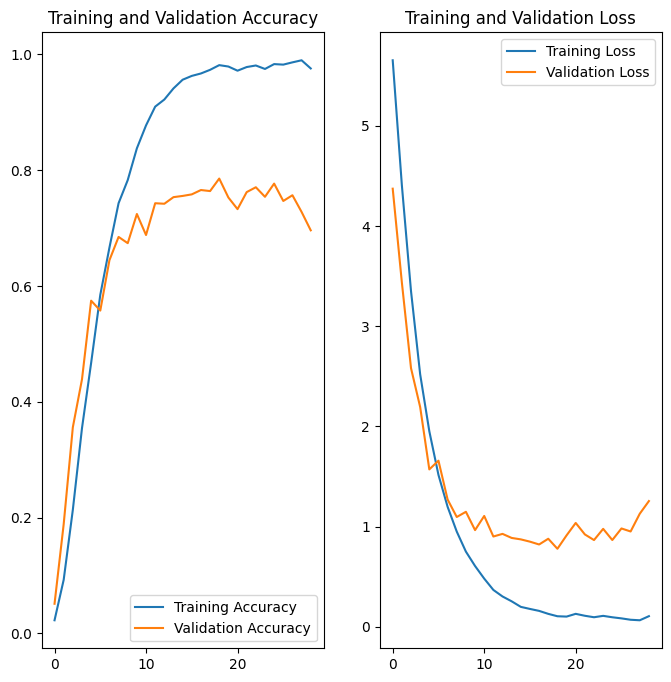

In [ ]:
summarise_history(history, num_epochs-1)

After training the model, we can evaluate it in our test data. Here, we can see that we achieved an accuracy of 0.80!! :D

In [ ]:
score = model.evaluate(test_set, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

209/209 [==============================] - 17s 80ms/step - loss: 0.7512 - accuracy: 0.7963
Summary: Loss over the test dataset: 0.75, Accuracy: 0.80


Now, we are going to load the final model saved in the Checkpoints to make predictions and generate the confusion matrix and classification report, which includes the Precision, Recall, F1 and Accuracy metrics.

Please, update the path with the location of the Checkpoint provided. Its file name is `densenet-model-1.h5`

In [ ]:
final_model = keras.models.load_model('/content/drive/MyDrive/Checkpoints_DL/densenet-model-1.h5')

In [ ]:
y_hat = final_model.predict(test_set)

209/209 [==============================] - 19s 75ms/step


In [ ]:
y_hat_index = np.argmax(y_hat, axis=1)

From this classification report and confusion matrix, we can see that the model performs very well in predicting almost all of the classes. However, it struggles with classes like 3 = '737-300', 12 = '747-300', 19 = '777-200' aircrafts.

In [ ]:
print(metrics.classification_report(test_df['Labels'], y_hat_index))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        33
           1       0.86      0.91      0.88        33
           2       0.96      0.65      0.77        34
           3       0.62      0.30      0.41        33
           4       0.70      0.70      0.70        33
           5       0.60      0.74      0.66        34
           6       0.79      0.67      0.72        33
           7       0.66      0.76      0.70        33
           8       0.60      0.76      0.68        34
           9       0.73      0.91      0.81        33
          10       0.43      0.61      0.51        33
          11       0.42      0.29      0.34        34
          12       0.43      0.36      0.39        33
          13       0.72      0.55      0.62        33
          14       0.74      0.85      0.79        34
          15       0.82      0.82      0.82        33
          16       0.51      0.82      0.63        33
          17       0.58    

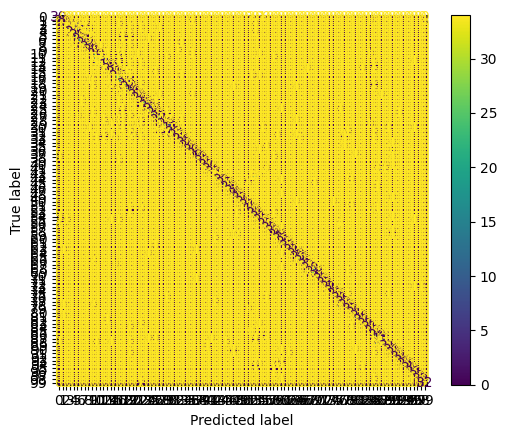

In [ ]:
cm= metrics.confusion_matrix(test_df['Labels'], y_hat_index)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Note**: This is to demonstrate one of the results of the different experiments mentioned at the beginning of this notebook. BUT it is not the final model. Therefore, DO NOT RUN THE CODE FROM THIS CELL ONWARDS.

### InceptionV3 trial

InceptionV3 has 311 layers. For instance, for this trial, I unfroze from the layer #100 and added layers on top, achieving an accuracy of no more than 0.68

In [ ]:
def create_model(num_classes, input_shape, optimizer, fine_tune_at, add_layers=False):

    base_model = InceptionV3(input_shape=input_shape, weights='imagenet', include_top = False)
    print("Number of layers in the base model: ", len(base_model.layers))

    if fine_tune_at > 0 :
      base_model.trainable = True
      for layer in base_model.layers[:fine_tune_at]:
          layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if add_layers:
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)

    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[base_model.input], outputs=[output])

    # Compile model
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
SGD_incep= SGD(learning_rate=1e-4, momentum=0.9)
model_3 = create_model(100, (512,512,3), SGD_incep, 100, True)

87910968/87910968 [==============================] - 1s 0us/step
Number of layers in the base model:  311


In [ ]:
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 520, 520, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 259, 259, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 259, 259, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 259, 259, 32)         0         ['batch_normalization[0][0

In [ ]:
checkpoint_incep = ModelCheckpoint(filepath='/content/drive/MyDrive/Checkpoints_DL/inception-model-3.keras', verbose=2, save_best_only=True)
stop_early_incep = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
num_epochs=50
history_3 = model_3.fit(train_set,
          epochs=num_epochs,
          validation_data=val_set,
          callbacks=[checkpoint_incep, stop_early_incep])

Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: 5.9979 - accuracy: 0.0123
Epoch 1: val_loss improved from inf to 4.63994, saving model to /content/drive/MyDrive/Checkpoints_DL/inception-model-3.keras
105/105 [==============================] - 386s 1s/step - loss: 5.9979 - accuracy: 0.0123 - val_loss: 4.6399 - val_accuracy: 0.0111
Epoch 2/50
104/105 [============================>.] - ETA: 0s - loss: 5.4703 - accuracy: 0.0264
Epoch 2: val_loss improved from 4.63994 to 4.52435, saving model to /content/drive/MyDrive/Checkpoints_DL/inception-model-3.keras
105/105 [==============================] - 43s 305ms/step - loss: 5.4695 - accuracy: 0.0264 - val_loss: 4.5244 - val_accuracy: 0.0264
Epoch 3/50
104/105 [============================>.] - ETA: 0s - loss: 5.0150 - accuracy: 0.0496
Epoch 3: val_loss improved from 4.52435 to 4.21587, saving model to /content/drive/MyDrive/Checkpoints_DL/inception-model-3.keras
105/105 [==============================] - 43s 300ms/step - 

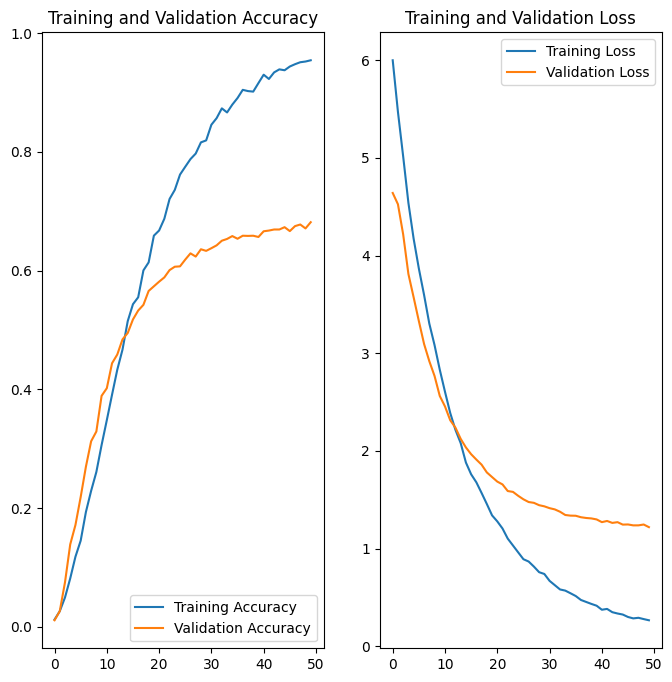

In [ ]:
summarise_history(history_3, num_epochs)

# References

Transfer learning and fine-tuning
https://www.tensorflow.org/tutorials/images/transfer_learning#feature_extraction

Keras Applications
https://keras.io/api/applications/

Densenet201
https://keras.io/api/applications/densenet/#densenet201-function

McDermott, J. Hands-on Transfer Learning with Keras and the VGG16 Model. LearnDataSci.
https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/